I've been exploring LoRA and am seeking a straightforward implementation example. Many resources I've found focus on training large models and often utilize PEFT and the loralib package, as well as some basic implementations using CNNs or ANNs as outlined in sources like [[2]].

I came across some examples using LoRA with BERT, DistillBert, and others involving a Linear() layer. However, I'm specifically interested in applying it to GPT2, which uses a Conv1D() layer instead of Linear().

These days, the deep learning models have significantly more layers. One major challenge with fine-tuning large models like GPT is their size; they often don't fit into the limited VRAM available. To address this, researchers at Microsoft developed the Low Rank Adaptation (LoRA) technique. This method leverages the principle of low-rank matrix decomposition. It has shown that common pre-trained models can be effectively fine-tuned or adapted using just a small subset of their original parameters, instead of modifying every parameter. This approach not only reduces the VRAM requirements but can be just as effective for fine-tuning purposes as using the full set of parameters.

LoRA approximates a layer's weight changes during training, ΔW, in a low-rank format.

For instance, whereas in regular finetuning, we compute the weight updates of a weight matrix W as ΔW, in LoRA, we approximate ΔW through the matrix multiplication of two smaller matrices AB, as illustrated in the figure below. (If you are familiar with PCA or SVD, consider this as decomposing ΔW into A and B.)

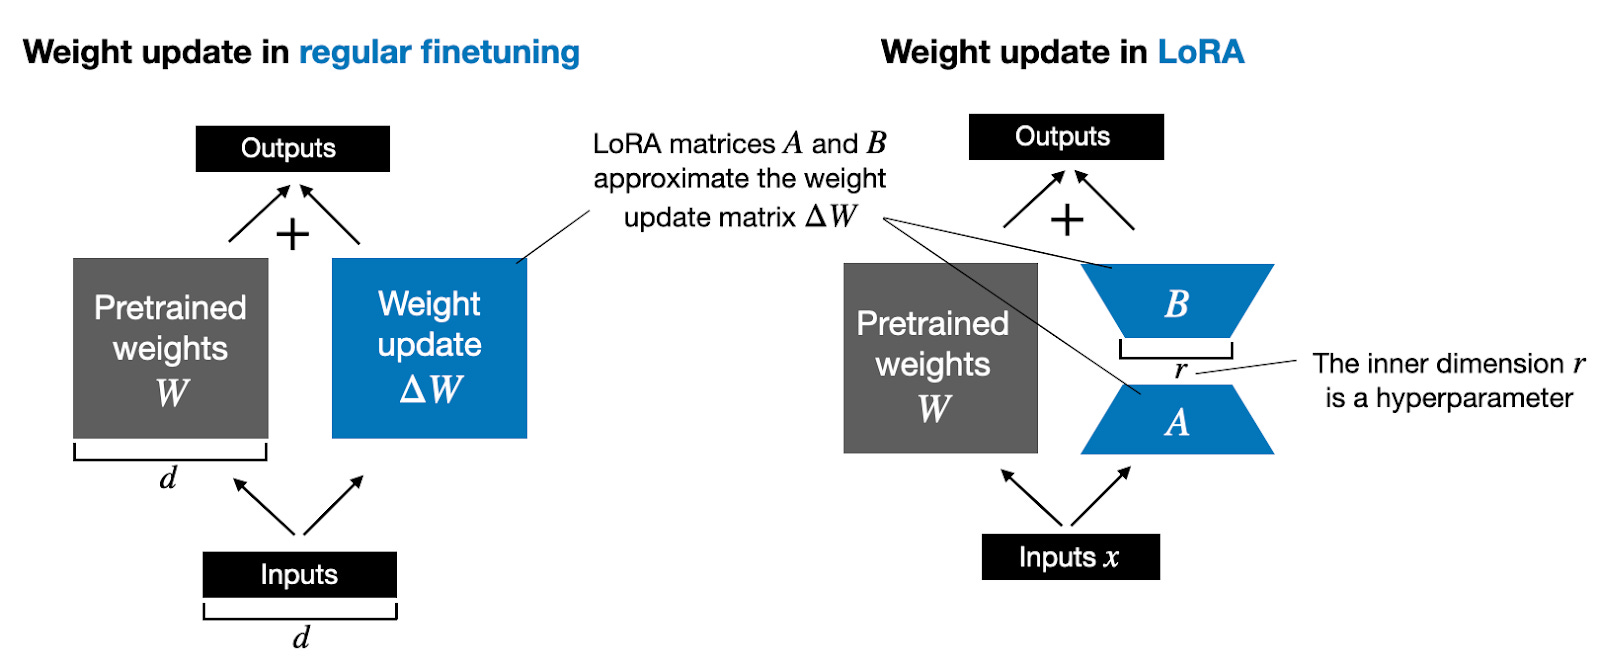

With LoRA, the transformation in a particular layer that originally involved just \($ W.x $\) (where \($ W $\) is the weight matrix and \($ x $\) is the input), now involves \( $ W.x + (W_A W_B).x $\):

1. **Original Operation**: \( Wx \)
   - Here, \($ W $\) is a large matrix, typically with dimensions like \($ 768 \times 768 $\) in models like BERT or GPT-2. The computational complexity of this operation is \($ O(d^2) $\), where \( d \) is the dimension of \($ W $\) (assuming square matrices for simplicity).

2. **LoRA Operation**: \($ Wx + (W_A W_B) x $\)
   - \($ W_A $\) and \($ W_B $\) are smaller matrices with dimensions \( $d \times r $\) and \( $r \times d $ \) respectively, where \( r \) is much smaller than \( d \) (low rank).
   - The product \($ W_A W_B $\) thus has the same dimension as \($ W $\) but is composed of a product of two smaller matrices, which reduces the computational load:
     - First, \($ W_A W_B $\) is computed, which involves \($ O(d^2 \cdot r)$ \).
     - Then, this product is multiplied by \($ x $\), \($ (W_A W_B)x $\), with complexity \($ O(d^2) $\) similar to the original, but the prior reduction in complexity helps.



For instance, consider a weight matrix W in a specific layer, sized at 2,000x10,000, totaling 20 million parameters. If we opt for a rank r=3, we would set up two new matrices: a 2,000x3 matrix B and an 3x10,000 matrix A. Together, matrices A and B contain just 6000 + 30,000 = 36,000 parameters, making them over 555 times smaller than the 20 million parameters typically involved in standard fine-tuning with ΔW.


In [ ]:
!pip install pytorch-lightning lightning accelerate transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 2.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_

In [ ]:
import pandas as pd
import numpy as np
import re
import math

from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init


# Data Preprocess

In [ ]:
def cleaning(s):
    s = str(s)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace("[\w*"," ")
    return s

In [ ]:
# dataset link https://www.kaggle.com/datasets/asad1m9a9h6mood/news-articles
df = pd.read_csv("./Articles.csv", encoding="ISO-8859-1")
df = df.dropna()
text_data = open('Articles.txt', 'w')
for idx, item in df.iterrows():
  article = cleaning(item["Article"])
  text_data.write(article)
text_data.close()

In [ ]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset


def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

# Download pretrained GPT2 model

In [ ]:
model = GPT2LMHeadModel.from_pretrained(model_name)
print(model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


Contrary to the examples referenced, this model doesn't use a Linear() layer but instead features a Conv1D() layer, which is mathematically equivalent. The concept remains the same, though the implementation differs. Let's proceed by creating a LoRA wrapper specifically tailored for it.

Note that we have frozen the base models parameters so only lora weights get trained.

# Conv1D Lora Wrapper

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class LoRAConv1DWrapper(nn.Module):
    """
    A wrapper module that applies LORA to the weights of a convolutional layer.
    """

    def __init__(self, module: nn.Module, rank: int):
        """
        Initializes the LoRAConv1DWrapper instance.

        Parameters:
            module (nn.Module): The base module whose weights are to be adapted.
            rank (int): The rank for the low-rank matrices A and B. If set to 0, LoRA is effectively disabled.
        """
        super().__init__()
        if rank < 0:
            raise ValueError("Rank must be a non-negative integer")

        self.base_module = module

        out_features, in_features = self.base_module.weight.shape

        self.lora_rank = rank
        if self.lora_rank > 0:
            self.W_A = nn.Parameter(
                torch.zeros((self.lora_rank, in_features)),
                requires_grad=True)
            self.W_B = nn.Parameter(
                torch.zeros((out_features, self.lora_rank)),
                requires_grad=True)

            # self.print_trainable_parameters()

            # freeze the base module's parameters, only focus on updating lora weights
            self.base_module.weight.requires_grad = False
            if self.base_module.bias is not None:
                self.base_module.bias.requires_grad = False
        else:
            print(f"Creating LoRAConv1DWrapper with no rank adaptation: rank {self.lora_rank}")

        self.reset_parameters()

    def reset_parameters(self):
        """
        Initializes or resets the parameters of the LoRA matrices A and B to their default values.
        This method typically mirrors the initialization logic of the base module.
        """
        if self.lora_rank > 0:
            # initialize A matrix
            nn.init.kaiming_uniform_(self.W_A, a=math.sqrt(5))
            # initialize B matrix to 0
            nn.init.zeros_(self.W_B)

    def print_trainable_parameters(self):
        """
        Prints the number of trainable parameters in the base module and the additional parameters added by LoRA.
        """
        base_params = sum(p.numel() for p in self.base_module.parameters())
        lora_params = sum(p.numel() for p in [self.W_A, self.W_B])

        print(f"Trainable parameters in base module: {base_params}")
        print(f"Trainable parameters in LoRA (base module frozen): {lora_params}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the LoRAConv1DWrapper, applying low-rank adaptations to the base module's weights.

        Parameters:
            x (torch.Tensor): The input tensor to the module.

        Returns:
            torch.Tensor: The output of the module after applying the low-rank adapted forward pass.
        """
        if self.lora_rank > 0:
            # Compute the base module's forward pass with adapted weights
            # print(self.W_A.shape)
            # print(self.W_B.shape)
            adapted_weight = self.base_module.weight + self.W_B @ self.W_A
            return F.linear(x, adapted_weight.T, self.base_module.bias)
        else:
            # Perform a standard forward pass using the base module's original weights and bias
            return F.linear(x, self.base_module.weight, self.base_module.bias)


In [ ]:
def update_model_layers(model):
  # Set LoRA hyperparameters
  lora_r = 8
  lora_alpha = 16
  lora_dropout = 0.05
  # flag to apply LoRA to Transformer layers
  lora_attn = True
  # flag to apply LoRA to MLP layers
  lora_mlp = True

  # Apply LoRA modifications to the GPT2 layers
  for block in model.transformer.h:
      if lora_attn:
        block.attn.c_attn = LoRAConv1DWrapper(block.attn.c_attn, rank=2)
        block.attn.c_proj = LoRAConv1DWrapper(block.attn.c_proj, rank=2)

      if lora_mlp:
          block.mlp.c_fc = LoRAConv1DWrapper(block.mlp.c_fc, rank=2)
          block.mlp.c_proj = LoRAConv1DWrapper(block.mlp.c_proj, rank=2)
  return model

In [ ]:
print(update_model_layers(model))

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): LoRAConv1DWrapper(
            (base_module): Conv1D()
          )
          (c_proj): LoRAConv1DWrapper(
            (base_module): Conv1D()
          )
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): LoRAConv1DWrapper(
            (base_module): Conv1D()
          )
          (c_proj): LoRAConv1DWrapper(
            (base_module): Conv1D()
          )
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm

In [ ]:
def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  """
    Trains a GPT-2 model using the Hugging Face Transformers library.

    This function initializes a model, tokenizer, and data collator. It sets up training arguments and
    creates a Trainer instance to manage the training process.

    Parameters:
    - train_file_path (str): The file path to the training dataset.
    - model_name (str): The name of the pre-trained GPT-2 model to use. This can be a model identifier
        from Hugging Face's model hub (e.g., 'gpt2', 'gpt2-medium') or the path to a local directory containing model files.
    - output_dir (str): The directory where the model checkpoints will be saved during training.
    - overwrite_output_dir (bool): Set to True to overwrite the output directory, or False to continue training from the last checkpoint.
    - per_device_train_batch_size (int): Batch size per device during training.
    - num_train_epochs (int): Total number of training epochs.
    - save_steps (int): The number of training steps to perform before saving a checkpoint.

    Returns:
    None

    Saves the tokenizer and model to the specified output directory. Trains the model using the
    given dataset, saving the final model configuration to the output directory after training.

    """
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  train_dataset = load_dataset(train_file_path, tokenizer)
  data_collator = load_data_collator(tokenizer)

  tokenizer.save_pretrained(output_dir)

  model = GPT2LMHeadModel.from_pretrained(model_name)

  # # comment this to skip LoRA
  model = update_model_layers(model)

  model.save_pretrained(output_dir)

  training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
      )

  trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
  )

  trainer.train()
  trainer.save_model()

As we can see Conv1D has successfully been replaced by the LoRAConv1DWrapper layer.

In [ ]:
# some constants
train_file_path = "Articles.txt"
model_name = 'gpt2'
output_dir = 'result'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 12
save_steps = 500

In [ ]:
train(
    train_file_path=train_file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss
500,4.064600
1000,3.789000
1500,3.625300
2000,3.547800
2500,3.474000
3000,3.430200
3500,3.381100
4000,3.350400
4500,3.311500
5000,3.292600


## Training without Lora 5 Epochs


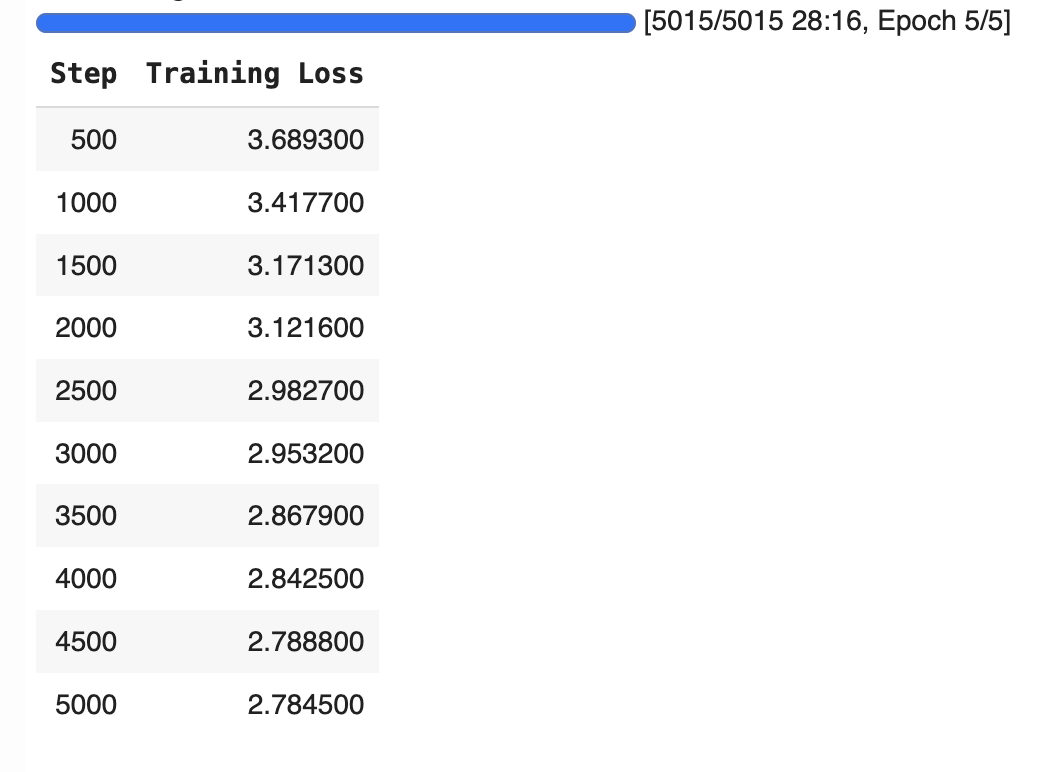

Let's attempt to lengthen the epochs using Lora; this might help reduce the loss further.

## Training with Lora 5 epochs

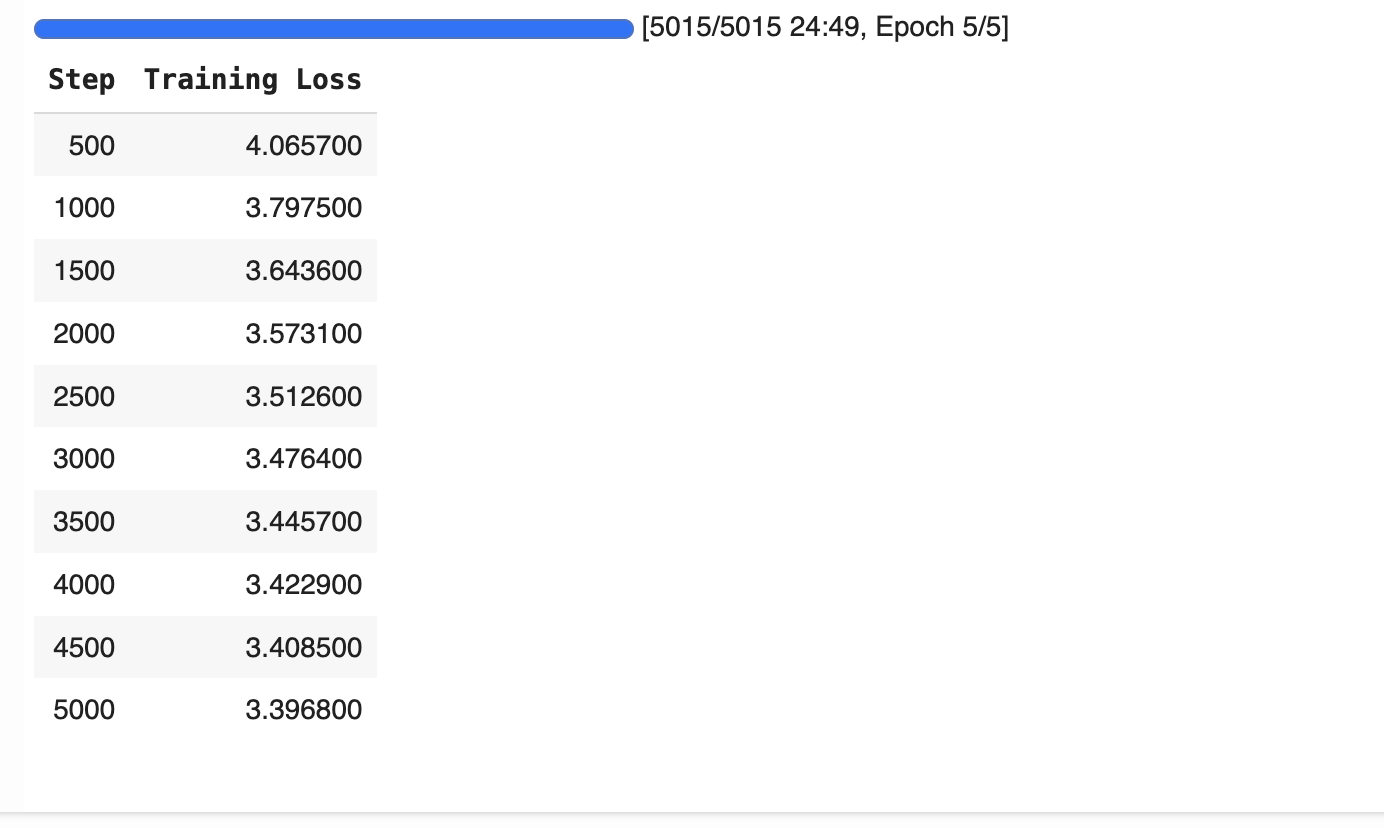

## Training with Lora 12 Epochs

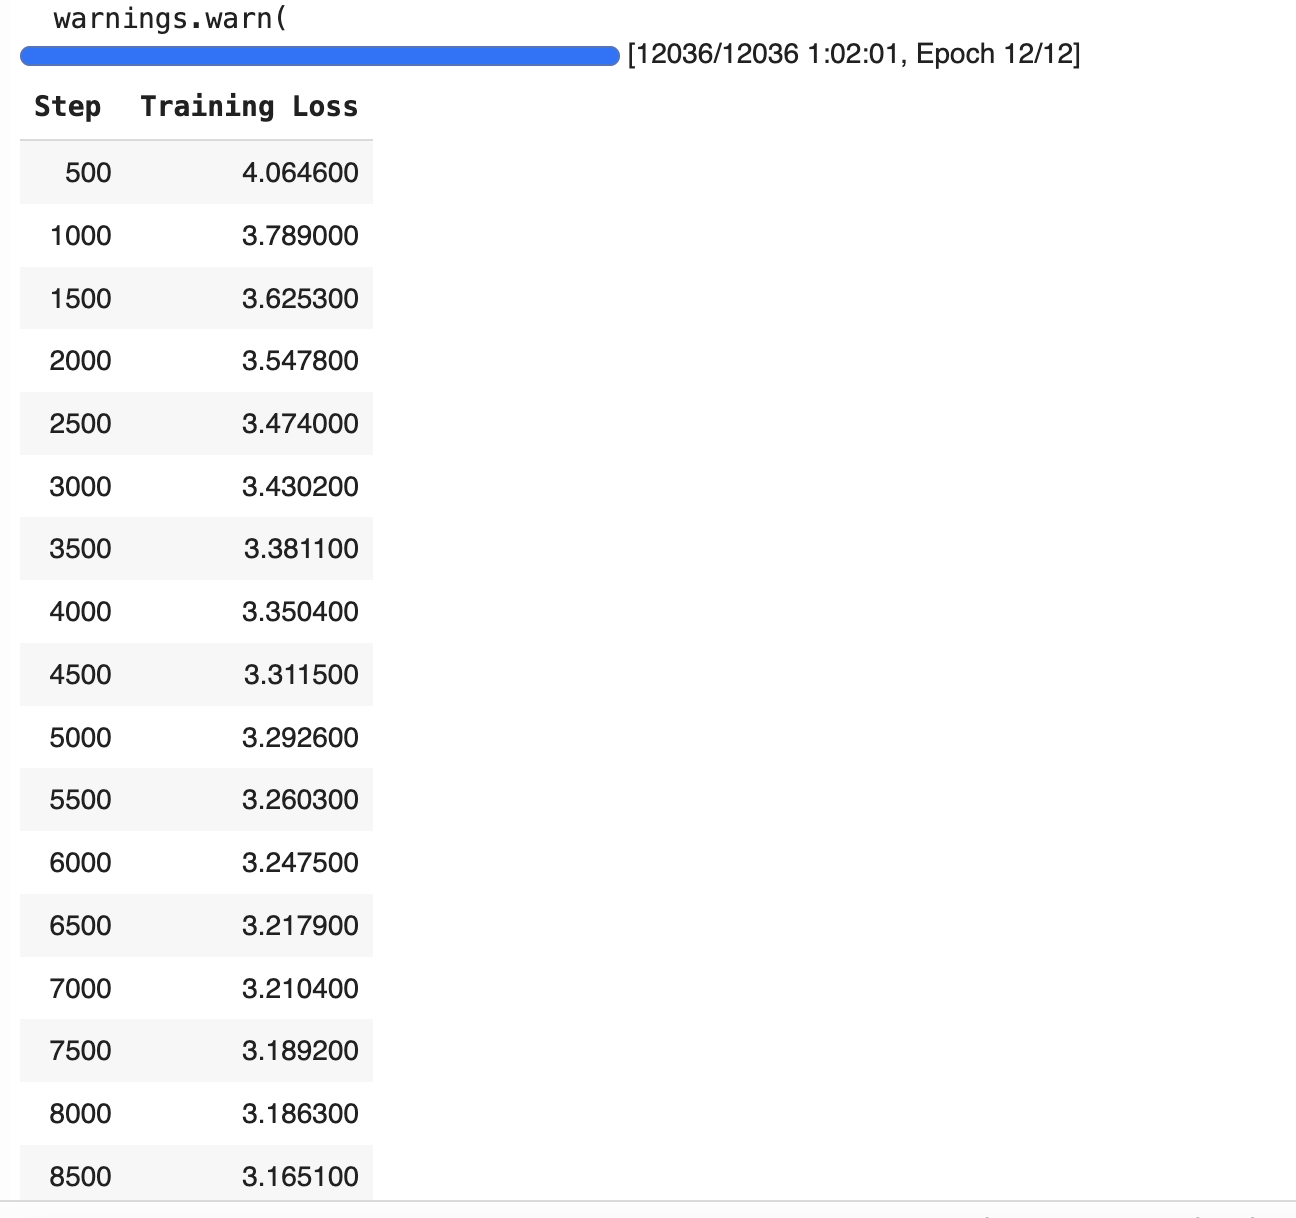

# References

[1] https://www.linkedin.com/pulse/more-efficient-finetuning-implementing-lora-from-scratch-george-davis/

[2] https://lightning.ai/lightning-ai/studios/code-lora-from-scratch

[3] https://towardsdatascience.com/implementing-lora-from-scratch-20f838b046f1

[4] LoRA explained (and a bit about precision and quantization)
 https://youtu.be/t509sv5MT0w


